# 자치구별 내용 포함 1km 피처 중요도 높은 피처로 모델링

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import Ridge, LinearRegression, ElasticNet, Lasso
%matplotlib inline
from scipy import stats
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
import xgboost as xgb
import lightgbm as lgb
import shap
from lightgbm import plot_importance
from xgboost import plot_importance


#분석 세팅
plt.rcParams['font.family'] = 'Malgun Gothic'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', 3000)
pd.set_option('display.max_columns', 300)

#데이터 불러오기
data1= pd.read_csv('C:\\Users\\chldy\\Desktop\\3학년 1학기\\기계학습\\table\\TABLE_2015.csv', encoding='utf-8')
data2= pd.read_csv('C:\\Users\\chldy\\Desktop\\3학년 1학기\\기계학습\\table\\TABLE_2016.csv', encoding='utf-8')
data3= pd.read_csv('C:\\Users\\chldy\\Desktop\\3학년 1학기\\기계학습\\table\\TABLE_2017.csv', encoding='utf-8')
data=pd.concat([data1, data2], axis=0)
data=pd.concat([data, data3], axis=0)

#size 피처 평수만 가져오기
data['size']=data['size'].str.split(' ').str[1]
data['size']=data['size'].str.split('㎡').str[0]
data= data.astype({'size':'float'})
data=data.dropna()

#1km변수만 가져옴
data_1=data.filter(regex='_1')

#앞의 변수중 필요한 변수 select
list_fo= [1, 6,  9]
data_2= data.iloc[:, list_fo]

#뒤의 변수중 다중공선성 작은 변수 select
list_gu=[ 87, 88, 91, 94, 98, 99, 101, 103, 105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 127, 129, 131, 133, 135]
data_3=data.iloc[:, list_gu]
all=pd.concat([data_2, data_1], axis=1)
all=pd.concat([all, data_3], axis=1)


y_data= all['success']
all=all.drop('success', axis=1)


#평가 지표 정의

def adj_r2_score(y_true, y_pred, p=train.shape[1]):
    return 1-(1-r2_score(y_true, y_pred)) * (len(y_true)-1) / (len(y_true) - p - 1)

        
def rmsle(y, pred):
    log_y= np.log1p(y)
    log_pred= np.log1p(pred)
    squared_error= (log_y- log_pred)**2
    rmsle= np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

def evaluate_regr(y, pred):
    rmsle_val= rmsle(y, pred)
    rmse_val= rmse(y, pred)
    print(rmsle_val, rmse_val)

#train, test 데이터 분리
x_train, x_test, y_train, y_test= train_test_split(all, y_data, test_size=0.2, random_state=2022)
ntrain=x_train.shape[0]
ntest=x_test.shape[0]

#target 데이터 로그 정규화
y_train=np.log1p(y_train)


#feature중 왜도가 높은 피처 로그정규화
all_x=pd.concat((x_train, x_test)).reset_index(drop=True)

numeric_feats= all_x.dtypes[all_x.dtypes!='object'].index

skewed_feats= all_x[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness= pd.DataFrame({'Skew': skewed_feats})
skewness.head(10)

skewness= skewness[abs(skewness)>0.75]



skewed_features= skewness.index
lam=0.15
for feat in skewed_features:
    all_x[feat]=boxcox1p(all_x[feat], lam)
    
#범주형 변수 변환   
all_x=pd.get_dummies(all_x)

train=all_x[:ntrain]
test=all_x[ntrain:]

n_folds = 5

#CV
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=10).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring='neg_mean_squared_error', cv = kf))
    return(rmse)

#LinearRegression
LR= LinearRegression()
score=rmsle_cv(LR)
print('\nLinear Regression cv score: {:.4f} '.format(score.mean()))
      
#lasso
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.005, random_state=1))
score = rmsle_cv(lasso)
print('\nLasso cv score: {:.4f}'.format(score.mean()))
      

#Decision Tree
DT= DecisionTreeRegressor(min_samples_split=3, max_depth=7, random_state=10)
score= rmsle_cv(DT)
print('\nDecisionTree cv score: {:.4f}'.format(score.mean()))

DT.fit(train, y_train)
DT_pred= np.expm1(DT.predict(test.values))
print('rmsle:{:.4f}'.format(rmsle(y_test, DT_pred)))
print('DecisionTree adj_R2 score:{:.4f}'.format( adj_r2_score(y_test, DT_pred)))

#Lgbm
LGBM = lgb.LGBMRegressor(objective='regression',num_leaves=7,
                              learning_rate=0.03, n_estimators=1000, random_state=10)

score = rmsle_cv(LGBM)
print('\nLGBM cv score: {:.4f} '.format(score.mean()))

LGBM.fit(train, y_train)
lgb_pred = np.expm1(LGBM.predict(test.values))
print('rmsle:{:.4f} '.format( rmsle(y_test, lgb_pred)))
print('LGBM adj_R2 score :{:.4f}' .format(adj_r2_score(y_test, lgb_pred)))



feature_importance_df = pd.DataFrame()
feature_importance_df["feature"] = train.columns
feature_importance_df["importance"] = LGBM.feature_importances_





all_features = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)
all_features.reset_index(inplace=True)
important_features = list(all_features[0:30]['feature'])
train = train[important_features]
test=test[important_features]

#Lgbm
LGBM = lgb.LGBMRegressor(objective='regression',num_leaves=7,
                              learning_rate=0.03, n_estimators=1000, random_state=10)

score = rmsle_cv(LGBM)
print('\nLGBM cv score: {:.4f} '.format(score.mean()))

LGBM.fit(train, y_train)
lgb_pred = np.expm1(LGBM.predict(test.values))
print('rmsle:{:.4f} '.format( rmsle(y_test, lgb_pred)))
print('LGBM adj_R2 score :{:.4f}' .format(adj_r2_score(y_test, lgb_pred)))



Linear Regression cv score: 0.7808 

Lasso cv score: 0.7702

DecisionTree cv score: 0.7685
rmsle:0.6993
DecisionTree adj_R2 score:0.8273

LGBM cv score: 0.6147 
rmsle:0.5681 
LGBM adj_R2 score :0.7148

LGBM cv score: 0.6150 
rmsle:0.5622 
LGBM adj_R2 score :0.7210


# 1km 모든모델

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import Ridge, LinearRegression, ElasticNet, Lasso
%matplotlib inline
from scipy import stats
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
import xgboost as xgb
import lightgbm as lgb
import shap
from lightgbm import plot_importance
from xgboost import plot_importance



#분석 세팅
plt.rcParams['font.family'] = 'Malgun Gothic'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', 3000)
pd.set_option('display.max_columns', 300)

#데이터 불러오기
data1= pd.read_csv('C:\\Users\\chldy\\Desktop\\3학년 1학기\\기계학습\\table\\TABLE_2015.csv', encoding='utf-8')
data2= pd.read_csv('C:\\Users\\chldy\\Desktop\\3학년 1학기\\기계학습\\table\\TABLE_2016.csv', encoding='utf-8')
data3= pd.read_csv('C:\\Users\\chldy\\Desktop\\3학년 1학기\\기계학습\\table\\TABLE_2017.csv', encoding='utf-8')
data=pd.concat([data1, data2], axis=0)
data=pd.concat([data, data3], axis=0)

#size 피처 평수만 가져오기
data['size']=data['size'].str.split(' ').str[1]
data['size']=data['size'].str.split('㎡').str[0]
data= data.astype({'size':'float'})
data=data.dropna()

#1km변수만 가져옴
data_1=data.filter(regex='_1')

#앞의 변수중 필요한 변수 select
list_fo= [1,6,  9]
data_2= data.iloc[:, list_fo]

#뒤의 변수중 다중공선성 작은 변수 select
list_gu=[ 87, 88, 91, 94, 98, 99, 101, 103, 105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 127, 129, 131, 133, 135]
data_3=data.iloc[:, list_gu]
all=pd.concat([data_2, data_1], axis=1)
all=pd.concat([all, data_3], axis=1)


y_data= all['success']
all=all.drop('success', axis=1)


#평가 지표 정의
def adj_r2_score(y_true, y_pred, p=train.shape[1]):
    return 1-(1-r2_score(y_true, y_pred)) * (len(y_true)-1) / (len(y_true) - p - 1)


def rmsle(y, pred):
    log_y= np.log1p(y)
    log_pred= np.log1p(pred)
    squared_error= (log_y- log_pred)**2
    rmsle= np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

def evaluate_regr(y, pred):
    rmsle_val= rmsle(y, pred)
    rmse_val= rmse(y, pred)
    print(rmsle_val, rmse_val)

#train, test 데이터 분리
x_train, x_test, y_train, y_test= train_test_split(all, y_data, test_size=0.2, random_state=2022)
ntrain=x_train.shape[0]
ntest=x_test.shape[0]

#target 데이터 로그 정규화
y_train=np.log1p(y_train)


#feature중 왜도가 높은 피처 로그정규화
all_x=pd.concat((x_train, x_test)).reset_index(drop=True)

numeric_feats= all_x.dtypes[all_x.dtypes!='object'].index

skewed_feats= all_x[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness= pd.DataFrame({'Skew': skewed_feats})
skewness.head(10)

skewness= skewness[abs(skewness)>0.75]



skewed_features= skewness.index
lam=0.15
for feat in skewed_features:
    all_x[feat]=boxcox1p(all_x[feat], lam)
    
#범주형 변수 변환   
all_x=pd.get_dummies(all_x)

train=all_x[:ntrain]
test=all_x[ntrain:]

n_folds = 5

#CV
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=10).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring='neg_mean_squared_error', cv = kf))
    return(rmse)

#LinearRegression
LR= LinearRegression()
score=rmsle_cv(LR)
print('\nLinear Regression cv score: {:.4f} '.format(score.mean()))
      
#lasso
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.005, random_state=1))
score = rmsle_cv(lasso)
print('\nLasso cv score: {:.4f}'.format(score.mean()))
      

#Decision Tree
DT= DecisionTreeRegressor(min_samples_split=3, max_depth=7, random_state=10)
score= rmsle_cv(DT)
print('\nDecisionTree cv score: {:.4f}'.format(score.mean()))

DT.fit(train, y_train)
DT_pred= np.expm1(DT.predict(test.values))
print('rmsle:{:.4f}'.format(rmsle(y_test, DT_pred)))
print('DecisionTree R2 score:{:.4f}'.format( adj_r2_score(y_test, DT_pred)))

#Lgbm
LGBM = lgb.LGBMRegressor(objective='regression',num_leaves=7,
                              learning_rate=0.03, n_estimators=1000, random_state=10)

score = rmsle_cv(LGBM)
print('\nLGBM cv score: {:.4f} '.format(score.mean()))

LGBM.fit(train, y_train)
lgb_pred = np.expm1(LGBM.predict(test.values))
print('rmsle:{:.4f} '.format( rmsle(y_test, lgb_pred)))
print('LGBM adj_R2 score :{:.4f}' .format(adj_r2_score(y_test, lgb_pred)))


#XGBM
XGB = xgb.XGBRegressor(learning_rate=0.02,
                       n_estimators=1000,
                       max_depth= 7 ,
                       gamma=0.06,
                       reg_lambda=0.54,
                       reg_alpha=0.52)

score = rmsle_cv(XGB)
print('\nXGB cv score: {:.4f} '.format(score.mean()))

XGB.fit(train, y_train)
xgb_pred = np.expm1(XGB.predict(test))
print('rmsle:{:.4f} '.format(rmsle(y_test, xgb_pred)))
print('XGB R2 score :{:.4f}' .format(adj_r2_score(y_test, xgb_pred)))



#RandomForest
RF= RandomForestRegressor(n_estimators=700, max_depth=15, min_samples_split=5,random_state=10)
score=rmsle_cv(RF)
print('\nRandomForest cv score: {:.4f} '.format(score.mean()))

RF.fit(train, y_train)
RF_pred = np.expm1(RF.predict(test.values))
print('rmsle: {:.4f}'.format( rmsle(y_test, RF_pred)))
print('RF R2 score :{:.4f}'.format(adj_r2_score(y_test, RF_pred)))

# LGBM shap 모델
explainer = shap.Explainer(LGBM)
shap_values = explainer(train)

shap.plots.waterfall(shap_values[0])

shap.plots.bar(shap_values)
shap.summary_plot(shap_values, train)
plot_importance(LGBM, max_num_features=15)


Linear Regression cv score: 0.7808 

Lasso cv score: 0.7702

DecisionTree cv score: 0.7685
rmsle:0.6993
DecisionTree R2 score:0.8280

LGBM cv score: 0.6147 
rmsle:0.5681 
LGBM adj_R2 score :0.7159


# 0.4km 자치구별 내용 o

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import Ridge, LinearRegression, ElasticNet, Lasso
%matplotlib inline
from scipy import stats
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
import xgboost as xgb
import lightgbm as lgb
import shap
from lightgbm import plot_importance
from xgboost import plot_importance



#분석 세팅
plt.rcParams['font.family'] = 'Malgun Gothic'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', 3000)
pd.set_option('display.max_columns', 300)

#데이터 불러오기
data1= pd.read_csv('C:\\Users\\chldy\\Desktop\\3학년 1학기\\기계학습\\table\\TABLE_2015.csv', encoding='utf-8')
data2= pd.read_csv('C:\\Users\\chldy\\Desktop\\3학년 1학기\\기계학습\\table\\TABLE_2016.csv', encoding='utf-8')
data3= pd.read_csv('C:\\Users\\chldy\\Desktop\\3학년 1학기\\기계학습\\table\\TABLE_2017.csv', encoding='utf-8')
data=pd.concat([data1, data2], axis=0)
data=pd.concat([data, data3], axis=0)

#size 피처 평수만 가져오기
data['size']=data['size'].str.split(' ').str[1]
data['size']=data['size'].str.split('㎡').str[0]
data= data.astype({'size':'float'})
data=data.dropna()

#1km변수만 가져옴
data_1=data.filter(regex='_0.4')

#앞의 변수중 필요한 변수 select
list_fo= [1,6,  9]
data_2= data.iloc[:, list_fo]

#뒤의 변수중 다중공선성 작은 변수 select
list_gu=[ 87, 88, 91, 94, 98, 99, 101, 103, 105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 127, 129, 131, 133, 135]
data_3=data.iloc[:, list_gu]
all=pd.concat([data_2, data_1], axis=1)
all=pd.concat([all, data_3], axis=1)


y_data= all['success']
all=all.drop('success', axis=1)


#평가 지표 정의
def adj_r2_score(y_true, y_pred, p=train.shape[1]):
    return 1-(1-r2_score(y_true, y_pred)) * (len(y_true)-1) / (len(y_true) - p - 1)


def rmsle(y, pred):
    log_y= np.log1p(y)
    log_pred= np.log1p(pred)
    squared_error= (log_y- log_pred)**2
    rmsle= np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

def evaluate_regr(y, pred):
    rmsle_val= rmsle(y, pred)
    rmse_val= rmse(y, pred)
    print(rmsle_val, rmse_val)

#train, test 데이터 분리
x_train, x_test, y_train, y_test= train_test_split(all, y_data, test_size=0.2, random_state=2022)
ntrain=x_train.shape[0]
ntest=x_test.shape[0]

#target 데이터 로그 정규화
y_train=np.log1p(y_train)


#feature중 왜도가 높은 피처 로그정규화
all_x=pd.concat((x_train, x_test)).reset_index(drop=True)

numeric_feats= all_x.dtypes[all_x.dtypes!='object'].index

skewed_feats= all_x[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness= pd.DataFrame({'Skew': skewed_feats})
skewness.head(10)

skewness= skewness[abs(skewness)>0.75]



skewed_features= skewness.index
lam=0.15
for feat in skewed_features:
    all_x[feat]=boxcox1p(all_x[feat], lam)
    
#범주형 변수 변환   
all_x=pd.get_dummies(all_x)

train=all_x[:ntrain]
test=all_x[ntrain:]

n_folds = 5

#CV
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=10).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring='neg_mean_squared_error', cv = kf))
    return(rmse)

#LinearRegression
LR= LinearRegression()
score=rmsle_cv(LR)
print('\nLinear Regression cv score: {:.4f} '.format(score.mean()))
      
#lasso
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.005, random_state=1))
score = rmsle_cv(lasso)
print('\nLasso cv score: {:.4f}'.format(score.mean()))
      

#Decision Tree
DT= DecisionTreeRegressor(min_samples_split=3, max_depth=7, random_state=10)
score= rmsle_cv(DT)
print('\nDecisionTree cv score: {:.4f}'.format(score.mean()))

DT.fit(train, y_train)
DT_pred= np.expm1(DT.predict(test.values))
print('rmsle:{:.4f}'.format(rmsle(y_test, DT_pred)))
print('DecisionTree R2 score:{:.4f}'.format( adj_r2_score(y_test, DT_pred)))

#Lgbm
LGBM = lgb.LGBMRegressor(objective='regression',num_leaves=7,
                              learning_rate=0.03, n_estimators=1000, random_state=10)

score = rmsle_cv(LGBM)
print('\nLGBM cv score: {:.4f} '.format(score.mean()))

LGBM.fit(train, y_train)
lgb_pred = np.expm1(LGBM.predict(test.values))
print('rmsle:{:.4f} '.format( rmsle(y_test, lgb_pred)))
print('LGBM adj_R2 score :{:.4f}' .format(adj_r2_score(y_test, lgb_pred)))


#XGBM
XGB = xgb.XGBRegressor(learning_rate=0.02,
                       n_estimators=1000,
                       max_depth= 7 ,
                       gamma=0.06,
                       reg_lambda=0.54,
                       reg_alpha=0.52)

score = rmsle_cv(XGB)
print('\nXGB cv score: {:.4f} '.format(score.mean()))

XGB.fit(train, y_train)
xgb_pred = np.expm1(XGB.predict(test))
print('rmsle:{:.4f} '.format(rmsle(y_test, xgb_pred)))
print('XGB R2 score :{:.4f}' .format(adj_r2_score(y_test, xgb_pred)))



#RandomForest
RF= RandomForestRegressor(n_estimators=700, max_depth=15, min_samples_split=5,random_state=10)
score=rmsle_cv(RF)
print('\nRandomForest cv score: {:.4f} '.format(score.mean()))

RF.fit(train, y_train)
RF_pred = np.expm1(RF.predict(test.values))
print('rmsle: {:.4f}'.format( rmsle(y_test, RF_pred)))
print('RF R2 score :{:.4f}'.format(adj_r2_score(y_test, RF_pred)))

# LGBM shap 모델
explainer = shap.Explainer(LGBM)
shap_values = explainer(train)

shap.plots.waterfall(shap_values[0])

shap.plots.bar(shap_values)
shap.summary_plot(shap_values, train)
plot_importance(LGBM, max_num_features=15)


Linear Regression cv score: 0.7833 

Lasso cv score: 0.7709

DecisionTree cv score: 0.7688
rmsle:0.6902


NameError: name 'adj_r2_score' is not defined

# 0.6km 자치구별 내용 o


Linear Regression cv score: 0.2758 

Lasso cv score: 0.2754

DecisionTree cv score: 0.1538
rmsle:0.1444
DecisionTree R2 score:0.6592

LGBM cv score: 0.1400 
rmsle:0.1224 
LGBM R2 score :0.9500


Glyph 8722 missing from current font.
Glyph 8722 missing from current font.


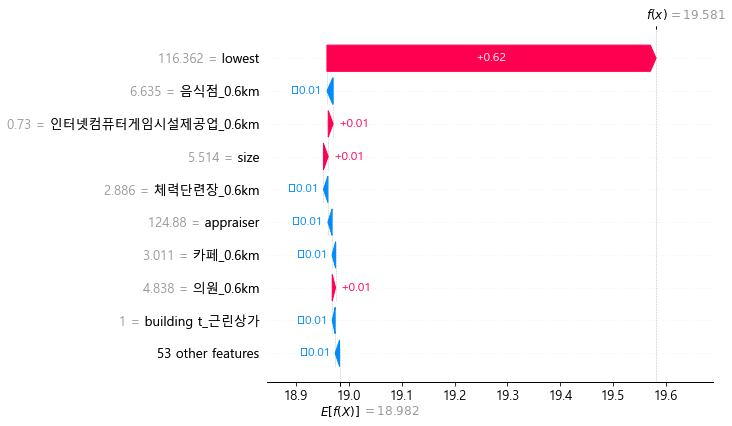

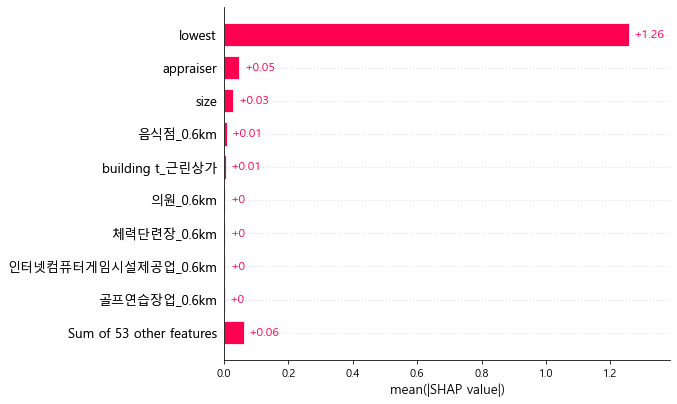


RandomForest cv score: 0.1228 
rmsle: 0.1142
RF R2 score :0.9789


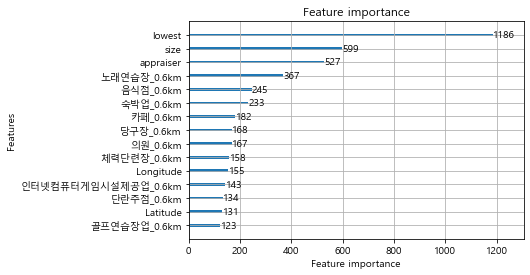

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import Ridge, LinearRegression, ElasticNet, Lasso
%matplotlib inline
from scipy import stats
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
import xgboost as xgb
import lightgbm as lgb
import shap
from lightgbm import plot_importance
from xgboost import plot_importance



#분석 세팅
plt.rcParams['font.family'] = 'Malgun Gothic'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', 3000)
pd.set_option('display.max_columns', 300)

#데이터 불러오기
data1= pd.read_csv('C:\\Users\\chldy\\Desktop\\3학년 1학기\\기계학습\\table\\TABLE_2015.csv', encoding='utf-8')
data2= pd.read_csv('C:\\Users\\chldy\\Desktop\\3학년 1학기\\기계학습\\table\\TABLE_2016.csv', encoding='utf-8')
data3= pd.read_csv('C:\\Users\\chldy\\Desktop\\3학년 1학기\\기계학습\\table\\TABLE_2017.csv', encoding='utf-8')
data=pd.concat([data1, data2], axis=0)
data=pd.concat([data, data3], axis=0)

#size 피처 평수만 가져오기
data['size']=data['size'].str.split(' ').str[1]
data['size']=data['size'].str.split('㎡').str[0]
data= data.astype({'size':'float'})
data=data.dropna()

#1km변수만 가져옴
data_1=data.filter(regex='_0.6')

#앞의 변수중 필요한 변수 select
list_fo= [1,6,  9]
data_2= data.iloc[:, list_fo]

#뒤의 변수중 다중공선성 작은 변수 select
list_gu=[ 87, 88, 91, 94, 98, 99, 101, 103, 105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 127, 129, 131, 133, 135]
data_3=data.iloc[:, list_gu]
all=pd.concat([data_2, data_1], axis=1)
all=pd.concat([all, data_3], axis=1)


y_data= all['success']
all=all.drop('success', axis=1)


#평가 지표 정의
def adj_r2_score(y_true, y_pred, p=train.shape[1]):
    return 1-(1-r2_score(y_true, y_pred)) * (len(y_true)-1) / (len(y_true) - p - 1)


def rmsle(y, pred):
    log_y= np.log1p(y)
    log_pred= np.log1p(pred)
    squared_error= (log_y- log_pred)**2
    rmsle= np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

def evaluate_regr(y, pred):
    rmsle_val= rmsle(y, pred)
    rmse_val= rmse(y, pred)
    print(rmsle_val, rmse_val)

#train, test 데이터 분리
x_train, x_test, y_train, y_test= train_test_split(all, y_data, test_size=0.2, random_state=2022)
ntrain=x_train.shape[0]
ntest=x_test.shape[0]

#target 데이터 로그 정규화
y_train=np.log1p(y_train)


#feature중 왜도가 높은 피처 로그정규화
all_x=pd.concat((x_train, x_test)).reset_index(drop=True)

numeric_feats= all_x.dtypes[all_x.dtypes!='object'].index

skewed_feats= all_x[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness= pd.DataFrame({'Skew': skewed_feats})
skewness.head(10)

skewness= skewness[abs(skewness)>0.75]



skewed_features= skewness.index
lam=0.15
for feat in skewed_features:
    all_x[feat]=boxcox1p(all_x[feat], lam)
    
#범주형 변수 변환   
all_x=pd.get_dummies(all_x)

train=all_x[:ntrain]
test=all_x[ntrain:]

n_folds = 5

#CV
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=10).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring='neg_mean_squared_error', cv = kf))
    return(rmse)

#LinearRegression
LR= LinearRegression()
score=rmsle_cv(LR)
print('\nLinear Regression cv score: {:.4f} '.format(score.mean()))
      
#lasso
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.005, random_state=1))
score = rmsle_cv(lasso)
print('\nLasso cv score: {:.4f}'.format(score.mean()))
      

#Decision Tree
DT= DecisionTreeRegressor(min_samples_split=3, max_depth=7, random_state=10)
score= rmsle_cv(DT)
print('\nDecisionTree cv score: {:.4f}'.format(score.mean()))

DT.fit(train, y_train)
DT_pred= np.expm1(DT.predict(test.values))
print('rmsle:{:.4f}'.format(rmsle(y_test, DT_pred)))
print('DecisionTree R2 score:{:.4f}'.format( adj_r2_score(y_test, DT_pred)))

#Lgbm
LGBM = lgb.LGBMRegressor(objective='regression',num_leaves=7,
                              learning_rate=0.03, n_estimators=1000, random_state=10)

score = rmsle_cv(LGBM)
print('\nLGBM cv score: {:.4f} '.format(score.mean()))

LGBM.fit(train, y_train)
lgb_pred = np.expm1(LGBM.predict(test.values))
print('rmsle:{:.4f} '.format( rmsle(y_test, lgb_pred)))
print('LGBM adj_R2 score :{:.4f}' .format(adj_r2_score(y_test, lgb_pred)))


#XGBM
XGB = xgb.XGBRegressor(learning_rate=0.02,
                       n_estimators=1000,
                       max_depth= 7 ,
                       gamma=0.06,
                       reg_lambda=0.54,
                       reg_alpha=0.52)

score = rmsle_cv(XGB)
print('\nXGB cv score: {:.4f} '.format(score.mean()))

XGB.fit(train, y_train)
xgb_pred = np.expm1(XGB.predict(test))
print('rmsle:{:.4f} '.format(rmsle(y_test, xgb_pred)))
print('XGB R2 score :{:.4f}' .format(adj_r2_score(y_test, xgb_pred)))



#RandomForest
RF= RandomForestRegressor(n_estimators=700, max_depth=15, min_samples_split=5,random_state=10)
score=rmsle_cv(RF)
print('\nRandomForest cv score: {:.4f} '.format(score.mean()))

RF.fit(train, y_train)
RF_pred = np.expm1(RF.predict(test.values))
print('rmsle: {:.4f}'.format( rmsle(y_test, RF_pred)))
print('RF R2 score :{:.4f}'.format(adj_r2_score(y_test, RF_pred)))

# LGBM shap 모델
explainer = shap.Explainer(LGBM)
shap_values = explainer(train)

shap.plots.waterfall(shap_values[0])

shap.plots.bar(shap_values)
shap.summary_plot(shap_values, train)
plot_importance(LGBM, max_num_features=15)

# 0.8km 자치구별 내용 o


Linear Regression cv score: 0.2790 

Lasso cv score: 0.2769

DecisionTree cv score: 0.1496
rmsle:0.1624
DecisionTree R2 score:0.7829

LGBM cv score: 0.1420 
rmsle:0.1229 
LGBM R2 score :0.9785


Glyph 8722 missing from current font.
Glyph 8722 missing from current font.


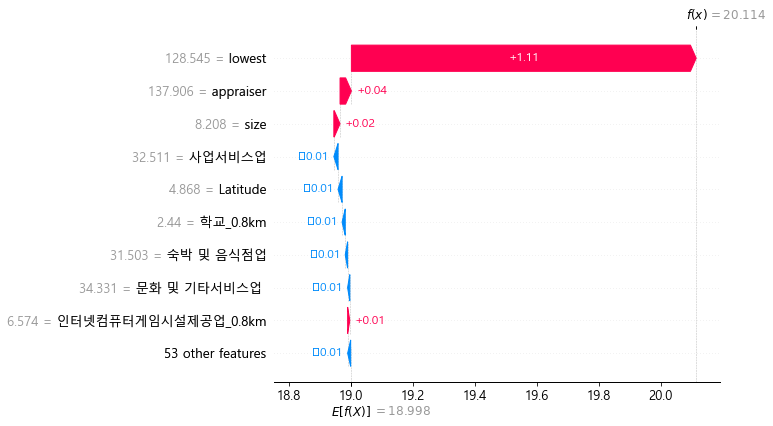

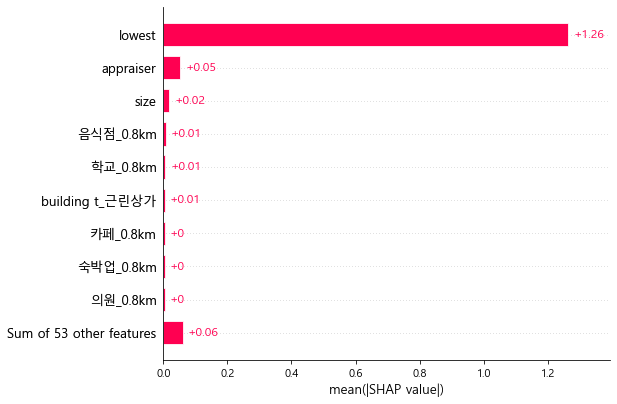


RandomForest cv score: 0.1229 
rmsle: 0.1218
RF R2 score :0.9954


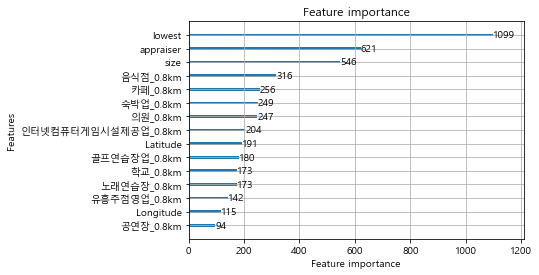

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import Ridge, LinearRegression, ElasticNet, Lasso
%matplotlib inline
from scipy import stats
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
import xgboost as xgb
import lightgbm as lgb
import shap
from lightgbm import plot_importance
from xgboost import plot_importance



#분석 세팅
plt.rcParams['font.family'] = 'Malgun Gothic'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', 3000)
pd.set_option('display.max_columns', 300)

#데이터 불러오기
data1= pd.read_csv('C:\\Users\\chldy\\Desktop\\3학년 1학기\\기계학습\\table\\TABLE_2015.csv', encoding='utf-8')
data2= pd.read_csv('C:\\Users\\chldy\\Desktop\\3학년 1학기\\기계학습\\table\\TABLE_2016.csv', encoding='utf-8')
data3= pd.read_csv('C:\\Users\\chldy\\Desktop\\3학년 1학기\\기계학습\\table\\TABLE_2017.csv', encoding='utf-8')
data=pd.concat([data1, data2], axis=0)
data=pd.concat([data, data3], axis=0)

#size 피처 평수만 가져오기
data['size']=data['size'].str.split(' ').str[1]
data['size']=data['size'].str.split('㎡').str[0]
data= data.astype({'size':'float'})
data=data.dropna()

#1km변수만 가져옴
data_1=data.filter(regex='_0.8')

#앞의 변수중 필요한 변수 select
list_fo= [1,6,  9]
data_2= data.iloc[:, list_fo]

#뒤의 변수중 다중공선성 작은 변수 select
list_gu=[ 87, 88, 91, 94, 98, 99, 101, 103, 105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 127, 129, 131, 133, 135]
data_3=data.iloc[:, list_gu]
all=pd.concat([data_2, data_1], axis=1)
all=pd.concat([all, data_3], axis=1)


y_data= all['success']
all=all.drop('success', axis=1)


#평가 지표 정의
def adj_r2_score(y_true, y_pred, p=train.shape[1]):
    return 1-(1-r2_score(y_true, y_pred)) * (len(y_true)-1) / (len(y_true) - p - 1)


def rmsle(y, pred):
    log_y= np.log1p(y)
    log_pred= np.log1p(pred)
    squared_error= (log_y- log_pred)**2
    rmsle= np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

def evaluate_regr(y, pred):
    rmsle_val= rmsle(y, pred)
    rmse_val= rmse(y, pred)
    print(rmsle_val, rmse_val)

#train, test 데이터 분리
x_train, x_test, y_train, y_test= train_test_split(all, y_data, test_size=0.2, random_state=2022)
ntrain=x_train.shape[0]
ntest=x_test.shape[0]

#target 데이터 로그 정규화
y_train=np.log1p(y_train)


#feature중 왜도가 높은 피처 로그정규화
all_x=pd.concat((x_train, x_test)).reset_index(drop=True)

numeric_feats= all_x.dtypes[all_x.dtypes!='object'].index

skewed_feats= all_x[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness= pd.DataFrame({'Skew': skewed_feats})
skewness.head(10)

skewness= skewness[abs(skewness)>0.75]



skewed_features= skewness.index
lam=0.15
for feat in skewed_features:
    all_x[feat]=boxcox1p(all_x[feat], lam)
    
#범주형 변수 변환   
all_x=pd.get_dummies(all_x)

train=all_x[:ntrain]
test=all_x[ntrain:]

n_folds = 5

#CV
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=10).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring='neg_mean_squared_error', cv = kf))
    return(rmse)

#LinearRegression
LR= LinearRegression()
score=rmsle_cv(LR)
print('\nLinear Regression cv score: {:.4f} '.format(score.mean()))
      
#lasso
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.005, random_state=1))
score = rmsle_cv(lasso)
print('\nLasso cv score: {:.4f}'.format(score.mean()))
      

#Decision Tree
DT= DecisionTreeRegressor(min_samples_split=3, max_depth=7, random_state=10)
score= rmsle_cv(DT)
print('\nDecisionTree cv score: {:.4f}'.format(score.mean()))

DT.fit(train, y_train)
DT_pred= np.expm1(DT.predict(test.values))
print('rmsle:{:.4f}'.format(rmsle(y_test, DT_pred)))
print('DecisionTree R2 score:{:.4f}'.format( adj_r2_score(y_test, DT_pred)))

#Lgbm
LGBM = lgb.LGBMRegressor(objective='regression',num_leaves=7,
                              learning_rate=0.03, n_estimators=1000, random_state=10)

score = rmsle_cv(LGBM)
print('\nLGBM cv score: {:.4f} '.format(score.mean()))

LGBM.fit(train, y_train)
lgb_pred = np.expm1(LGBM.predict(test.values))
print('rmsle:{:.4f} '.format( rmsle(y_test, lgb_pred)))
print('LGBM adj_R2 score :{:.4f}' .format(adj_r2_score(y_test, lgb_pred)))


#XGBM
XGB = xgb.XGBRegressor(learning_rate=0.02,
                       n_estimators=1000,
                       max_depth= 7 ,
                       gamma=0.06,
                       reg_lambda=0.54,
                       reg_alpha=0.52)

score = rmsle_cv(XGB)
print('\nXGB cv score: {:.4f} '.format(score.mean()))

XGB.fit(train, y_train)
xgb_pred = np.expm1(XGB.predict(test))
print('rmsle:{:.4f} '.format(rmsle(y_test, xgb_pred)))
print('XGB R2 score :{:.4f}' .format(adj_r2_score(y_test, xgb_pred)))



#RandomForest
RF= RandomForestRegressor(n_estimators=700, max_depth=15, min_samples_split=5,random_state=10)
score=rmsle_cv(RF)
print('\nRandomForest cv score: {:.4f} '.format(score.mean()))

RF.fit(train, y_train)
RF_pred = np.expm1(RF.predict(test.values))
print('rmsle: {:.4f}'.format( rmsle(y_test, RF_pred)))
print('RF R2 score :{:.4f}'.format(adj_r2_score(y_test, RF_pred)))

# LGBM shap 모델
explainer = shap.Explainer(LGBM)
shap_values = explainer(train)

shap.plots.waterfall(shap_values[0])

shap.plots.bar(shap_values)
shap.summary_plot(shap_values, train)
plot_importance(LGBM, max_num_features=15)

# 2015 2016 2017 자치구별 x 1km

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import Ridge, LinearRegression, ElasticNet, Lasso
%matplotlib inline
from scipy import stats
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
import xgboost as xgb
import lightgbm as lgb
import shap
from lightgbm import plot_importance
from xgboost import plot_importance



#분석 세팅
plt.rcParams['font.family'] = 'Malgun Gothic'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', 3000)
pd.set_option('display.max_columns', 300)

#데이터 불러오기
data1= pd.read_csv('C:\\Users\\chldy\\Desktop\\3학년 1학기\\기계학습\\table\\TABLE_2015.csv', encoding='utf-8')
data2= pd.read_csv('C:\\Users\\chldy\\Desktop\\3학년 1학기\\기계학습\\table\\TABLE_2016.csv', encoding='utf-8')
data3= pd.read_csv('C:\\Users\\chldy\\Desktop\\3학년 1학기\\기계학습\\table\\TABLE_2017.csv', encoding='utf-8')
data=pd.concat([data1, data2], axis=0)
data=pd.concat([data, data3], axis=0)

#size 피처 평수만 가져오기
data['size']=data['size'].str.split(' ').str[1]
data['size']=data['size'].str.split('㎡').str[0]
data= data.astype({'size':'float'})
data=data.dropna()

#1km변수만 가져옴
data_1=data.filter(regex='_1')

#앞의 변수중 필요한 변수 select
list_fo= [1,6,  9]
data_2= data.iloc[:, list_fo]

#뒤의 변수중 다중공선성 작은 변수 select
list_gu=[ 87, 88, 91, 94, 98, 99, 101, 103, 105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 127, 129, 131, 133, 135]
data_3=data.iloc[:, list_gu]
all=pd.concat([data_2, data_1], axis=1)



y_data= all['success']
all=all.drop('success', axis=1)


#평가 지표 정의
def adj_r2_score(y_true, y_pred, p=train.shape[1]):
    return 1-(1-r2_score(y_true, y_pred)) * (len(y_true)-1) / (len(y_true) - p - 1)


def rmsle(y, pred):
    log_y= np.log1p(y)
    log_pred= np.log1p(pred)
    squared_error= (log_y- log_pred)**2
    rmsle= np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

def evaluate_regr(y, pred):
    rmsle_val= rmsle(y, pred)
    rmse_val= rmse(y, pred)
    print(rmsle_val, rmse_val)

#train, test 데이터 분리
x_train, x_test, y_train, y_test= train_test_split(all, y_data, test_size=0.2, random_state=2022)
ntrain=x_train.shape[0]
ntest=x_test.shape[0]

#target 데이터 로그 정규화
y_train=np.log1p(y_train)


#feature중 왜도가 높은 피처 로그정규화
all_x=pd.concat((x_train, x_test)).reset_index(drop=True)

numeric_feats= all_x.dtypes[all_x.dtypes!='object'].index

skewed_feats= all_x[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness= pd.DataFrame({'Skew': skewed_feats})
skewness.head(10)

skewness= skewness[abs(skewness)>0.75]



skewed_features= skewness.index
lam=0.15
for feat in skewed_features:
    all_x[feat]=boxcox1p(all_x[feat], lam)
    
#범주형 변수 변환   
all_x=pd.get_dummies(all_x)

train=all_x[:ntrain]
test=all_x[ntrain:]

n_folds = 5

#CV
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=10).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring='neg_mean_squared_error', cv = kf))
    return(rmse)

#LinearRegression
LR= LinearRegression()
score=rmsle_cv(LR)
print('\nLinear Regression cv score: {:.4f} '.format(score.mean()))
      
#lasso
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.005, random_state=1))
score = rmsle_cv(lasso)
print('\nLasso cv score: {:.4f}'.format(score.mean()))
      

#Decision Tree
DT= DecisionTreeRegressor(min_samples_split=3, max_depth=7, random_state=10)
score= rmsle_cv(DT)
print('\nDecisionTree cv score: {:.4f}'.format(score.mean()))

DT.fit(train, y_train)
DT_pred= np.expm1(DT.predict(test.values))
print('rmsle:{:.4f}'.format(rmsle(y_test, DT_pred)))
print('DecisionTree R2 score:{:.4f}'.format( adj_r2_score(y_test, DT_pred)))

#Lgbm
LGBM = lgb.LGBMRegressor(objective='regression',num_leaves=7,
                              learning_rate=0.03, n_estimators=1000, random_state=10)

score = rmsle_cv(LGBM)
print('\nLGBM cv score: {:.4f} '.format(score.mean()))

LGBM.fit(train, y_train)
lgb_pred = np.expm1(LGBM.predict(test.values))
print('rmsle:{:.4f} '.format( rmsle(y_test, lgb_pred)))
print('LGBM adj_R2 score :{:.4f}' .format(adj_r2_score(y_test, lgb_pred)))


#XGBM
XGB = xgb.XGBRegressor(learning_rate=0.02,
                       n_estimators=1000,
                       max_depth= 7 ,
                       gamma=0.06,
                       reg_lambda=0.54,
                       reg_alpha=0.52)

score = rmsle_cv(XGB)
print('\nXGB cv score: {:.4f} '.format(score.mean()))

XGB.fit(train, y_train)
xgb_pred = np.expm1(XGB.predict(test))
print('rmsle:{:.4f} '.format(rmsle(y_test, xgb_pred)))
print('XGB R2 score :{:.4f}' .format(adj_r2_score(y_test, xgb_pred)))



#RandomForest
RF= RandomForestRegressor(n_estimators=700, max_depth=15, min_samples_split=5,random_state=10)
score=rmsle_cv(RF)
print('\nRandomForest cv score: {:.4f} '.format(score.mean()))

RF.fit(train, y_train)
RF_pred = np.expm1(RF.predict(test.values))
print('rmsle: {:.4f}'.format( rmsle(y_test, RF_pred)))
print('RF R2 score :{:.4f}'.format(adj_r2_score(y_test, RF_pred)))

# LGBM shap 모델
explainer = shap.Explainer(LGBM)
shap_values = explainer(train)

shap.plots.waterfall(shap_values[0])

shap.plots.bar(shap_values)
shap.summary_plot(shap_values, train)
plot_importance(LGBM, max_num_features=15)


Linear Regression cv score: 0.8055 

Lasso cv score: 0.7899

DecisionTree cv score: 0.7918
rmsle:0.7411
DecisionTree R2 score:0.8843

LGBM cv score: 0.6170 
rmsle:0.5818 
LGBM adj_R2 score :0.7318
